#### Loading data

In [2]:
suppressPackageStartupMessages(library(TreeSummarizedExperiment))
suppressPackageStartupMessages(library(ape))
suppressPackageStartupMessages(library(phangorn))
metaData <- read.delim("/fs/cbcb-lab/rob/students/noor/Uncertainity/real_datasets/GSE100505_EDL_MAST/SRR_Acc_List.txt")
quantDir <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/real_datasets/GSE100505_EDL_MAST/sal_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100"
samples <- metaData$RUN
files <- file.path(quantDir, samples, "quant.sf")
colData <- cbind(data.frame(files = files, names = samples), condition = as.factor(metaData$TissueName))

saveDir <- "../environment/mouseMuscle"
clustFile <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/real_datasets/GSE100505_EDL_MAST/term_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/no_threshold0/cluster_nwk.txt"

tseCons <- beaveR::buildTSE(treeTermFile = clustFile, coldata = colData)
treeCons <- rowTree(tseCons)
l <- length(treeCons$tip)

yAll <- beaveR::computeSizeFactors(tseCons)
yAll <- beaveR::scInfReps(yAll)
yAll <- fishpond::labelKeep(yAll)
metadata(yAll)[["infRepsScaled"]] <- TRUE

seMuscle <- tximeta::tximeta(colData)
load(file.path(saveDir, "detNodes.RData"))

reading tree

importing quantifications

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 


found matching transcriptome:
[ GENCODE - Mus musculus - release M25 ]

loading existing TxDb created: 2023-02-17 18:26:37

Loading required package: GenomicFeatures

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: 'S4Vectors'


T

Progress:   1 on 100Progress:   2 on 100Progress:   3 on 100Progress:   4 on 100Progress:   5 on 100Progress:   6 on 100Progress:   7 on 100Progress:   8 on 100Progress:   9 on 100Progress:  10 on 100Progress:  11 on 100Progress:  12 on 100Progress:  13 on 100Progress:  14 on 100Progress:  15 on 100Progress:  16 on 100Progress:  17 on 100Progress:  18 on 100Progress:  19 on 100Progress:  20 on 100Progress:  21 on 100Progress:  22 on 100Progress:  23 on 100Progress:  24 on 100Progress:  25 on 100Progress:  26 on 100Progress:  27 on 100Progress:  28 on 100Progress:  29 on 100Progress:  30 on 100Progress:  31 on 100Progress:  32 on 100Progress:  33 on 100Progress:  34 on 100Progress:  35 on 100Progress:  36 on 100Progress:  37 on 100Progress:  38 on 100Progress:  39 on 100Progress:  40 on 100Progress:  41 on 100Progress:  42 on 100Progress:  43 on 100Progress:  44 on 100Progress:  45 on 100Progress:  46 on 100Progress:  47 on 100Progress:  48 on 100Progress:  49 on 100Progress:  50 on 100

In [28]:
termFile <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/real_datasets/GSE100505_EDL_MAST/term_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/old/SRR5758630/clusters.txt"
suppressPackageStartupMessages(source("../terminus_helper.R"))
yTermThrNS <- tseCons[1:l,]
groupsClust <- parseClustFile(termFile, yTermThrNS)
mInds <- seq(nrow(yTermThrNS) + length(groupsClust))
yAggTermThrNS <- prepTerm(yTermThrNS, mInds, groupsClust)

#### Differentially expressed transcripts

In [13]:
dTxps <- lapply(detNodes[["Txps"]], function(txps) rownames(tseCons)[txps])
sapply(dTxps, length)

[1] 3149 6849 9592

#### Genes Mapping to those transcripts

In [14]:
mapDf <- rowData(seMuscle)
txpGenes <- lapply(dTxps, function(txps) unique(unlist(mapDf[txps, "gene_id"])))##Genes that map to transcripts
sapply(txpGenes, length)

[1] 2685 5391 7121

#### Differentially expressed genes

In [18]:
gse <- tximeta::summarizeToGene(seMuscle)
dges <- lapply(detNodes[["Genes"]], function(genes) rownames(gse)[genes])
sapply(dges,length)

loading existing TxDb created: 2023-02-17 18:26:37

obtaining transcript-to-gene mapping from database

loading existing gene ranges created: 2023-02-21 05:37:24

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



[1] 2535 4494 5814

#### Genes that are considered differentially expressed in genes but dont contain a single differentially expressed transcript

In [19]:
diffGenes <- lapply(seq_along(dges), function(i) setdiff(dges[[i]], txpGenes[[i]])) ## Txps that are missing in differential transcripts mapping to genes
sapply(diffGenes, length)
diffGenes2 <- lapply(seq_along(dges), function(i) setdiff(txpGenes[[i]], dges[[i]])) ## Txps that are missing in differential transcripts mapping to genes                    
sapply(diffGenes2, length)
# sum(mcols(y)[unlist(mcols(yg)[diffGenes[[2]],"tx_ids"]), "qvalue"] < 0.05, na.rm=T)==0 ## None of the diffGenes should contain a differential transcript

[1] 685 839 907

[1]  835 1736 2214

#### Height of the nodes in treeclimbR and trenDi

In [24]:
lapply(detNodes$`treeClimbR(N)`, function(nodes) table(node.depth(treeCons,2)[nodes]))
lapply(detNodes$trenDi, function(nodes) table(node.depth(treeCons,2)[nodes]))

[[1]]

   1    2    3    4    5    6    7    8    9   10   11 
2491  249   75   34   28   17    7    4    2    1    1 

[[2]]

   1    2    3    4    5    6    7    8    9   10   11   12   13 
5259  485  192   57   56   36   13    7    3    3    1    1    1 

[[3]]

   1    2    3    4    5    6    7    8    9   10   11   12   13 
7449  580  231   76   61   39   15    9    4    3    1    1    1 


[[1]]

   1    2    3    4    5    6    7    8    9   10   11 
2522  651  295  134   59   28    8    7    4    1    2 

[[2]]

   1    2    3    4    5    6    7    8    9   10   11   13 
5406 1285  555  252  107   46   20   11    4    1    3    3 

[[3]]

   1    2    3    4    5    6    7    8    9   10   11   12   13 
7500 1698  696  308  130   62   31   17    6    4    3    1    2 


#### Transcripts mapping to the features

In [36]:
j <- 1
treeDETxps <- rownames(tseCons)[unlist(Descendants(treeCons, detNodes[["trenDi"]][[j]]))]
treeClimbTxps <- rownames(tseCons)[detNodes[["treeClimbR(L)"]][[j]]]

dN <- detNodes[["Terminus"]][[j]]

termTxps <- c(rownames(yTermThrNS)[dN][startsWith(rownames(yAggTermThrNS)[dN], "ENS")],
  rownames(yAggTermThrNS)[as.numeric(unlist(groupsClust[rownames(yAggTermThrNS)[dN][!startsWith(rownames(yAggTermThrNS)[dN], "ENS")]]))])

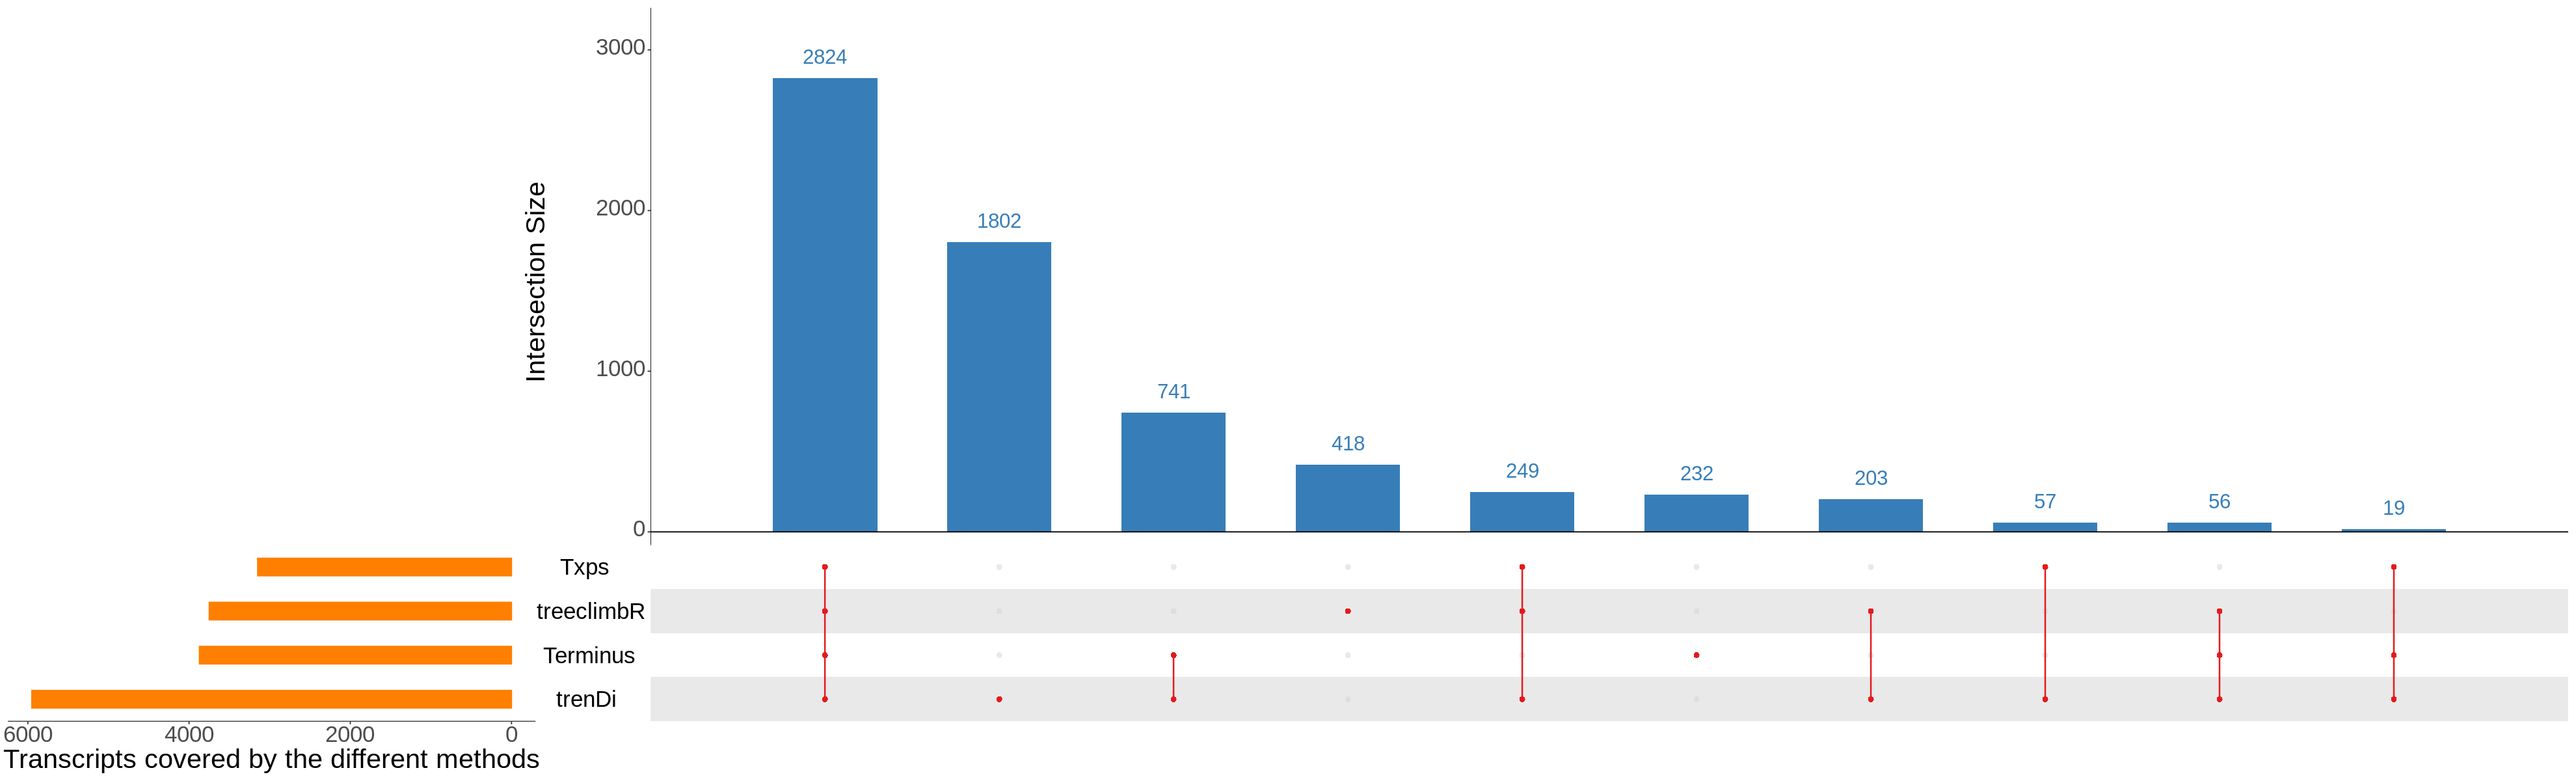

In [37]:
options(repr.plot.width=33, repr.plot.height=10)
suppressPackageStartupMessages(library(UpSetR))
txpMethods = list(Txps = rownames(tseCons)[detNodes[["Txps"]][[j]]], 
                 trenDi = treeDETxps, 
                 treeclimbR = treeClimbTxps, 
                 Terminus = termTxps
                 )
upsetData <- fromList(txpMethods)
size <- 3
upset(upsetData, order.by = "freq",
     main.bar.color = "#377eb8", 
     matrix.color = "#e41a1c",
     sets.bar.color = c("#ff7f00"),
     sets.x.label = "Transcripts covered by the different methods",
     shade.alpha = 0.7, 
     text.scale = c(size, size, size, size, size, size)
)

In [39]:
sapply(detNodes$`treeClimbR(N)`,length)
sapply(detNodes$trenDi,length)

[1] 2909 6114 8470

[1]  3711  7693 10458

#### Genes mapping to the trenDi nodes and their number

In [52]:
trenDiNodes <- detNodes[["trenDi"]]
genesTrenDi <- lapply(trenDiNodes, function(nodes) {
    lapply(Descendants(treeCons,nodes), function(desc) unique(unlist(mapDf[treeCons$tip[desc],"gene_id"])))})
sapply(genesTrenDi, function(genes) length(unique(unlist(genes)))) ## Number of genes mapping to treeDE nodes
sapply(genesTrenDi, function(nodes) table(sapply(nodes,length))) ## Distribution of number of genes and nodes

[1] 3255 6220 8010

[[1]]

   1    2    3    5 
3672   33    5    1 

[[2]]

   1    2    3    4 
7625   56    8    4 

[[3]]

    1     2     3     4     7     9 
10369    73     9     4     1     2 


#### Genes that map only to trenDi but are neither DE or covered by differential transcripts

In [54]:
### Nodes that dont cotain a DET
ll <- lapply(seq_along(trenDiNodes), function(i) {
    desc <- Descendants(treeCons, trenDiNodes[[i]])
    which(sapply(desc, function(txps) sum(txps %in% detNodes[["Txps"]][[i]]) == 0))
})

### Nodes that DO NOT contain a single DE gene
sapply(ll, length)
nodesNotDE <- lapply(seq_along(ll), function(i) {
    genesL <- genesTrenDi[[i]][ll[[i]]]
    ll[[i]][sapply(genesL, function(genes) sum(genes %in% dges[[i]]) == 0)]
})
sapply(nodesNotDE, length)

[1]  585  928 1009

[1] 231 382 390

#### Genes belonging to trenDi nodes that intersect with differentially expressed genes which do not a single differentially expressed transcript

In [61]:
trenDiDegNodes <- lapply(seq_along(genesTrenDi), function(i) {
    which(sapply(genesTrenDi[[i]], function(gs) sum(gs %in% diffGenes[[i]]) > 0))
})
sapply(trenDiDegNodes,length)
save(trenDiDegNodes, file=file.path(saveDir, "trenDiDegNodes.RData"))

[1] 309 428 465

##### Distribution of genes mapped to by such nodes in trenDi

In [67]:
sapply(seq_along(trenDiDegNodes), function(i) {
    table(sapply(genesTrenDi[[i]][trenDiDegNodes[[i]]], function(gs) length(gs)))
})

[[1]]

  1   2 
301   8 

[[2]]

  1   2   3 
421   6   1 

[[3]]

  1   2   3 
457   7   1 
